opening .geo: geo2
---------------
stream length in bytes  195154338
first two bytes:  b'\xd4\x05'
header length: 1492
Pixel 0 at 1494 bytes
Pixel 50 at 433934 bytes
Pixel 100 at 852658 bytes
Pixel 150 at 1177286 bytes
Pixel 200 at 1536670 bytes
Pixel 250 at 1939882 bytes
Pixel 300 at 2369206 bytes
Pixel 350 at 2792414 bytes
Pixel 400 at 3113538 bytes
Pixel 450 at 3452734 bytes
Pixel 500 at 3852734 bytes
Pixel 550 at 4280382 bytes
Pixel 600 at 4705338 bytes
Pixel 650 at 5024798 bytes
Pixel 700 at 5344266 bytes
Pixel 750 at 5739210 bytes
Pixel 800 at 6164014 bytes
Pixel 850 at 6591890 bytes
Pixel 900 at 6916446 bytes
Pixel 950 at 7215382 bytes
Pixel 1000 at 7605586 bytes
Pixel 1050 at 8026398 bytes
Pixel 1100 at 8456022 bytes
Pixel 1150 at 8785098 bytes
Pixel 1200 at 9071382 bytes
Pixel 1250 at 9447774 bytes
Pixel 1300 at 9863462 bytes
Pixel 1350 at 10295202 bytes
Pixel 1400 at 10631958 bytes
Pixel 1450 at 10913798 bytes
Pixel 1500 at 11272426 bytes
Pixel 1550 at 11685442 bytes
Pixel 16

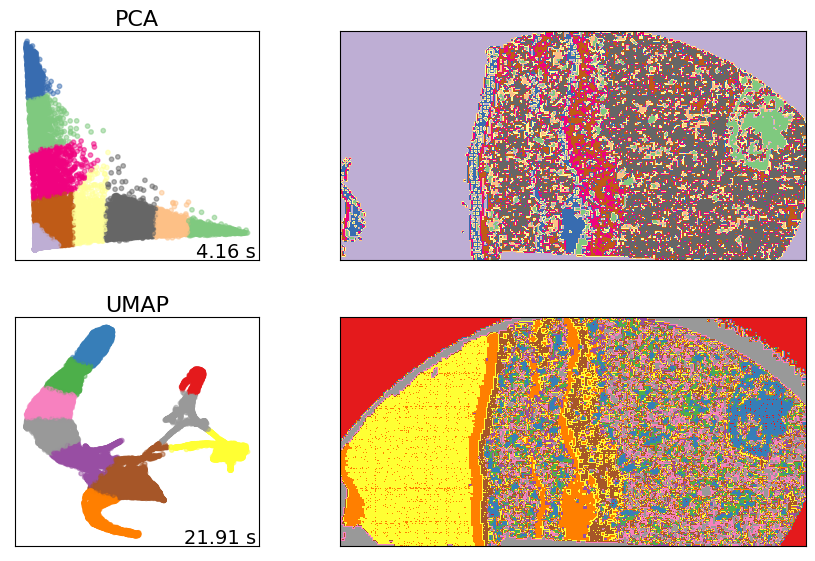

CLEAN COMPLETE


In [8]:
import os
import time
import gc
import time

import numpy as np
from sklearn import decomposition
import umap.umap_ as umap

import config
import src.utils as utils
import src.bitops as bitops
import src.colour as colour
import src.clustering as clustering

"""
Parses spectrum-by-pixel maps from IXRF XFM

- parses binary .GeoPIXE files
- extracts pixel parameters
- projects spectra onto simple RGB channels
- displays as RGB

./data has example dataset

SPEED
                t/px
reading only:   0.00014 
colourmap:      0.0078
read and clust  0.001296 

"""

#-----------------------------------
#CLASSES
#-----------------------------------
"""
reducers = [
    (manifold.TSNE, {"perplexity": 50}),
    # (manifold.LocallyLinearEmbedding, {'n_neighbors':10, 'method':'hessian'}),
    (manifold.Isomap, {"n_neighbors": 30}),
    (manifold.MDS, {}),
    (decomposition.PCA, {}),
    (umap.UMAP, {"n_neighbors": 30, "min_dist": 0.3}),
]
"""
reducers = [
    (decomposition.PCA, {}),
    (umap.UMAP, {"n_neighbors": 30, "min_dist": 0.3}),
]

#-----------------------------------
#INITIALISE
#-----------------------------------

starttime = time.time()             #init timer

totalpx=config.MAPX*config.MAPY     #map size
chan=np.arange(0,config.NCHAN)      #channels
energy=chan*config.ESTEP            #energy list

#-----------------------------------
#MAIN START
#-----------------------------------

#check filetype is recognised - currently only accepts .GeoPIXE
if config.FTYPE == ".GeoPIXE":
    f = os.path.join(config.wdir,config.infile)
    fname = os.path.splitext(os.path.basename(f))[0]

    print("opening .geo:",fname)
else: 
    print(f'FATAL: filetype {config.FTYPE} not recognised')
    exit()

print("---------------")


#open the datafile 
with open(f, mode='rb') as file: # rb = read binary
    
    #generate bytestream
    stream = file.read()         #NB. to read in chunks, add chunk size as read(SIZE)
    streamlen=len(stream)

    print("stream length in bytes ",streamlen)
    print("first two bytes: ",stream[:2])

    headerlen=bitops.binunpack(stream,0,"<H")[0]
    print(f"header length: {headerlen}")
    
    #check for missing header
    #   pixels start with "DP" (=20550 as <uint16)
    #   if we find this immediately, header is zero length
    if headerlen == 20550:
        print("WARNING: no header found")
        headerlen=0
    
    #assign starting pixel index 
    idx=headerlen+2 #legnth of header + 2 bytes

    #initialise pixel param arrays
    pxlen=np.zeros(totalpx)
    xidx=np.zeros(totalpx)
    yidx=np.zeros(totalpx)
    det=np.zeros(totalpx)
    dt=np.zeros(totalpx)
    
    if config.DOCOLOURS == True:
        #initalise pixel colour arrays
        rvals=np.zeros(totalpx)
        gvals=np.zeros(totalpx)
        bvals=np.zeros(totalpx)
        totalcounts=np.zeros(totalpx)

    #initialise data array
    data=np.zeros((totalpx,config.NCHAN))

    i=0 #pixel counter

    #loop through pixels
    while idx < streamlen:

        #print pixel index every 50 px
        if i % 50 == 0: print(f"Pixel {i} at {idx} bytes")

        #read pixel record into spectrum and header param arrays, 
        # + reassign index at end of read
        outchan, counts, pxlen[i], xidx[i], yidx[i], det[i], dt[i], idx = bitops.readpxrecord(idx, stream)

        #fill gaps in spectrum 
        #   (ie. add 0s for all missing chans)
        outchan, counts = utils.gapfill(outchan,counts, config.NCHAN)

        #warn if recieved channel list is different length to chan array
        if len(outchan) != len(chan):
            print("WARNING: channel list from pixel does not match expected")
      
        #assign counts into data array - 
        data[i,:]=counts

        #build colours if required
        if config.DOCOLOURS == True: rvals[i], bvals[i], gvals[i], totalcounts[i] = colour.spectorgb(energy, counts)
        
        #warn if i is unexpectedly high - would mostly happen if header is wrong
        if i > totalpx:
            print(f"WARNING: pixel count {i} exceeds expected map size {totalpx}")

        if (config.SHORTRUN == True) and (idx > streamlen*(config.skipratio/100)):
            print("ending at:", idx)
            idx=streamlen+1
        i+=1

    runtime = time.time() - starttime

    print(
        "---------------------------\n"
        "MAP COMPLETE\n"
        "---------------------------\n"
        f"pixels expected (X*Y): {totalpx}\n"
        f"pixels found: {i}\n"
        f"total time: {round(runtime,2)} s\n"
        f"time per pixel: {round((runtime/i),6)} s\n"
        "---------------------------"
    )

    #clear the bytestream from memory
    del stream
    gc.collect()

    if config.DOCOLOURS == True:
        colour.clcomplete(rvals, gvals, bvals, totalcounts)

    print("DOCLUST", config.DOCLUST)
    if config.DOCLUST:
        embedding, clusttimes = clustering.reduce(data)
        categories = clustering.dokmeans(embedding)
        print("categories full")
        print(categories)
        clustering.clustplt(embedding, categories, clusttimes)


    np.savetxt(os.path.join(config.odir, "pxlen.txt"), pxlen)
    np.savetxt(os.path.join(config.odir, "xidx.txt"), xidx)
    np.savetxt(os.path.join(config.odir, "yidx.txt"), yidx)
    np.savetxt(os.path.join(config.odir, "detector.txt"), det)
    np.savetxt(os.path.join(config.odir, "dt.txt"), dt)

print("CLEAN COMPLETE")

[0.         0.         0.         ... 0.02080405 0.01911723 0.02136632]
[0.         0.         0.         ... 0.00104603 0.00104603 0.00209205]
[0.         0.         0.         ... 0.00174064 0.00058021 0.00116043]
[0.         0.         0.         ... 0.00042034 0.00084069 0.00210172]
[0.         0.         0.         ... 0.00045851 0.00137552 0.        ]
[0.         0.         0.         ... 0.00190311 0.00294118 0.00138408]
[0.         0.         0.         ... 0.00162973 0.00097784 0.00097784]
[0.       0.       0.       ... 0.001386 0.000462 0.000462]
[0.         0.         0.         ... 0.00640079 0.01033973 0.00984737]
[0.         0.         0.         ... 0.00111982 0.00055991 0.00055991]


<function matplotlib.pyplot.show(close=None, block=None)>

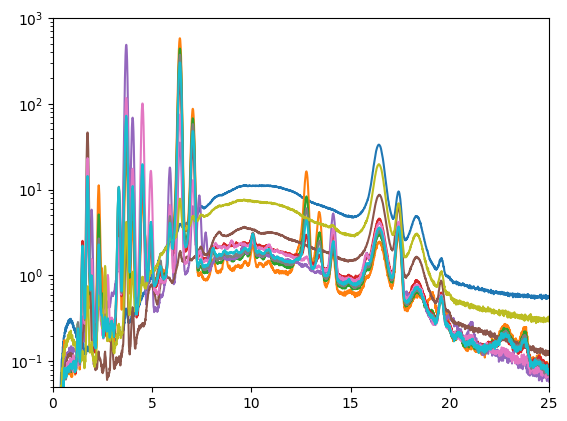

In [56]:
import matplotlib.pyplot as plt

ncats=10    #no. categories
nbins=4096
nred=2

sumspec=np.zeros([nred,ncats,nbins])

redidx=1
for i in range(ncats):
    datcat=data[categories[redidx]==i]
    pxincat, bins = datcat.shape
    sumspec[redidx,i,:]=(np.sum(datcat,axis=0))/pxincat
    print(sumspec[redidx,i,:])
    plt.plot(energy, sumspec[redidx,i,:])

plt.xlim(0,25)
plt.ylim(0.05,1000)
plt.yscale("log")
plt.show
